**TASK 1 : For the given metadata, i.e., text description and depths, generate the “best” possible output images.**

[ When needed feel free to combine depth with other forms of conditioning in
ControlNet like normals, canny etc. (you can extract them using the given
depths). ]

Step 1 - Installing & Importing the required libraries

In [ ]:
# installing libraries
!pip install diffusers transformers accelerate
!pip install torch torchvision
!pip install opencv-python
!pip install gdown
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 70.3 MB/s eta 0:00:00


In [ ]:
# importing libraries
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
from transformers import AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import gdown

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Step 2 - Loading the Metadata files

In [ ]:
metadata_link = "https://drive.google.com/drive/folders/1PQjUG8DQ7TPFABqR3ey_qZlFHyCclPIo"
gdown.download_folder(metadata_link, quiet=False, use_cookies=False)

!ls

Retrieving folder contents


Retrieving folder 1jdI_EvtK2X_b4ErIq856OXsme-Xehs6P Images
Processing file 1pBfjB5Cxipz18qxzHLMiSdcETwLPk97P 1.png
Processing file 1o75NJ8qMr0O6mmn0S9suaoJ15hD9lEfX 2.png
Processing file 1MFMf-PYGZd7Kn0gJmNupVZO3q2UhT4Z9 3.png
Processing file 1R_vBpehuyg-IWzXVBaBjgrpEvlXfL0Bn 4.png
Processing file 1iqIe8sRFnEZmnfwcUjunLhIQsbtdW9he 5.png
Processing file 1wxerYsNfN_ybIj_4rvBVp0JxH3SgdeS6 6.npy
Processing file 1mJiGsgEKcjcP3wexlUP-ku5L8ws2xpEx 7.npy
Retrieving folder 1ZOn5NumcORq_FlAH2JDg4tHESB9JASNy No Crop 
Processing file 1W87aE-TjstrJPf-zMvZgCaPcd9h8rcHI 2_nocrop.png
Processing file 1Bil_0NGBMJ-EBnMRob9YvJPiRGeewUzIoUnGAX003a8 prompts


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1pBfjB5Cxipz18qxzHLMiSdcETwLPk97P
To: /content/Metadata/Images/1.png
100%|██████████| 9.83k/9.83k [00:00<00:00, 14.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o75NJ8qMr0O6mmn0S9suaoJ15hD9lEfX
To: /content/Metadata/Images/2.png
100%|██████████| 101k/101k [00:00<00:00, 65.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MFMf-PYGZd7Kn0gJmNupVZO3q2UhT4Z9
To: /content/Metadata/Images/3.png
100%|██████████| 10.6k/10.6k [00:00<00:00, 11.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R_vBpehuyg-IWzXVBaBjgrpEvlXfL0Bn
To: /content/Metadata/Images/4.png
100%|██████████| 446k/446k [00:00<00:00, 87.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iqIe8sRFnEZmnfwcUjunLhIQsbtdW9he
To: /content/Metadata/Images/5.png
100%|██████████| 12.2k/12.2k [00:00<00:00, 10.3MB/s]
Downloading...
From: https://

Metadata  sample_data



Download completed


Step 3 - Loading the Text Prompts & Depth Maps


In [ ]:
import os
import cv2
import numpy as np

text_prompts_path = '/content/Metadata/prompts'
depth_maps_folder = '/content/Metadata/Images'

# loading the text prompts
with open(text_prompts_path, 'r', encoding='utf-8', errors='ignore') as file:
    prompts = file.readlines()

# loading the depth maps
def load_depth_map(file_path):
    if file_path.endswith('.npy'):
        return np.load(file_path)
    elif file_path.endswith('.png'):
        return cv2.imread(file_path, cv2.IMREAD_UNCHANGED) / 255.0
    else:
        raise ValueError("Unsupported file format for depth map")

    # scaling depth map to 255 if values are in range [0,1]
    if depth_map.max() <= 1.0:
        depth_map = (depth_map * 255).astype(np.uint8)

    # resizing depth map to the input size required by the model
    depth_map_resized = cv2.resize(depth_map, (512, 512))

    # ensuring depth map has 3 channels
    if len(depth_map_resized.shape) == 2:
        depth_map_resized = np.stack([depth_map_resized]*3, axis=-1)

    # resizing depth map to 512x512 & normalizing
    depth_map_resized = cv2.resize((depth_map * 255).astype(np.uint8), (512, 512))

    return depth_map_resized

depth_maps = []
for filename in os.listdir(depth_maps_folder):
    depth_map = load_depth_map(os.path.join(depth_maps_folder, filename))
    depth_maps.append(depth_map)

# confirm if depth_maps was loaded
if len(depth_maps) == 0:
    print("No depth maps loaded. Please check the file paths and formats.")
else:
    print(f"Loaded {len(depth_maps)} depth maps.")

Loaded 7 depth maps.


Step 4 - Setting up the Stable Diffusion & ControlNet pipelines

In [ ]:
!pip install -U --pre xformers

In [ ]:
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loading the ControlNet model with depth map guidance
controlnet_depth_model = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float32
).to(device)

# loading the Stable Diffusion pipeline with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet_depth_model,
    torch_dtype=torch.float32
).to(device)

# enabling memory-efficient attention
if device=='cuda':
  pipe.enable_xformers_memory_efficient_attention()

# setting a seed for reproducibility
generator = torch.manual_seed(12345)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Step 6 - Generating Images based on Prompts and Depth Maps

In [ ]:
# helper function to display images
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title, fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# function to truncate long prompts for CLIP (max length 77 tokens)
def truncate_prompt(prompt):
    max_token_length = 77
    tokens = prompt.split()  # Tokenize the prompt based on spaces
    if len(tokens) > max_token_length:
        truncated = ' '.join(tokens[:max_token_length])  # Take only the first 77 tokens
        return truncated
    return prompt

# generating images using each prompt and corresponding depth map
generated_images = []

for i, (prompt, depth_map) in enumerate(zip(prompts, depth_maps)):
  # resizing depth map to 512x512
  depth_map_resized = cv2.resize(depth_map, (512, 512))
  # ensuring depth map has 3 channels by stacking, if grayscale
  if len(depth_map_resized.shape) == 2:  # If the image is grayscale
    depth_map_resized = np.stack([depth_map_resized]*3, axis=-1)  # Convert to 3 channels
  # checking shape before expanding dimensions
  print(f"Depth map shape before expanding: {depth_map_resized.shape}")
  # adding batch dimension (1, 512, 512, 3)
  depth_map_resized = np.expand_dims(depth_map_resized, axis=0)
  # checking shape after expanding dimensions
  print(f"Depth map shape after expanding: {depth_map_resized.shape}")
  # converting depth map to torch tensor and move to the appropriate device
  depth_map_resized = torch.tensor(depth_map_resized).permute(0, 3, 1, 2).to(pipe.device)
  # checking tensor shape after conversion
  print(f"Tensor shape: {depth_map_resized.shape}")
  # truncating the prompt to handle CLIP's 77 token limit
  truncated_prompt = truncate_prompt(prompt.strip())
  # generating image using the pipeline
  try:
    generated_image = pipe(truncated_prompt, image=depth_map_resized, num_inference_steps=30).images[0]
  except Exception as e:
    print(f"Error generating image: {e}")
    continue
  # appending the generated image to the list
  generated_images.append(generated_image)
  # saving the generated image
  generated_image.save(f'generated_img_{i}.png')

# plotting the generated images
plot_images(generated_images, [f'Image {i}' for i in range(len(generated_images))], 3, 3)

NameError: name 'prompts' is not defined

**TASK 2 : Can we generate images of different aspect ratios (use “Metadata/Nocrop/2_nocrop.png” to test this out) using SD? Comment on the generation quality with respect to the aspect ratio of 1:1 for the same image.**

*We might exploit Stable Diffusion for generating images at various aspect ratios by varying the input resolution. The generation quality will be dependent on the aspect ratio.*

*Usually, the Stable Diffusion models are optimised for 1:1 aspect ration [i.e., 512 X 512 pixels]*

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

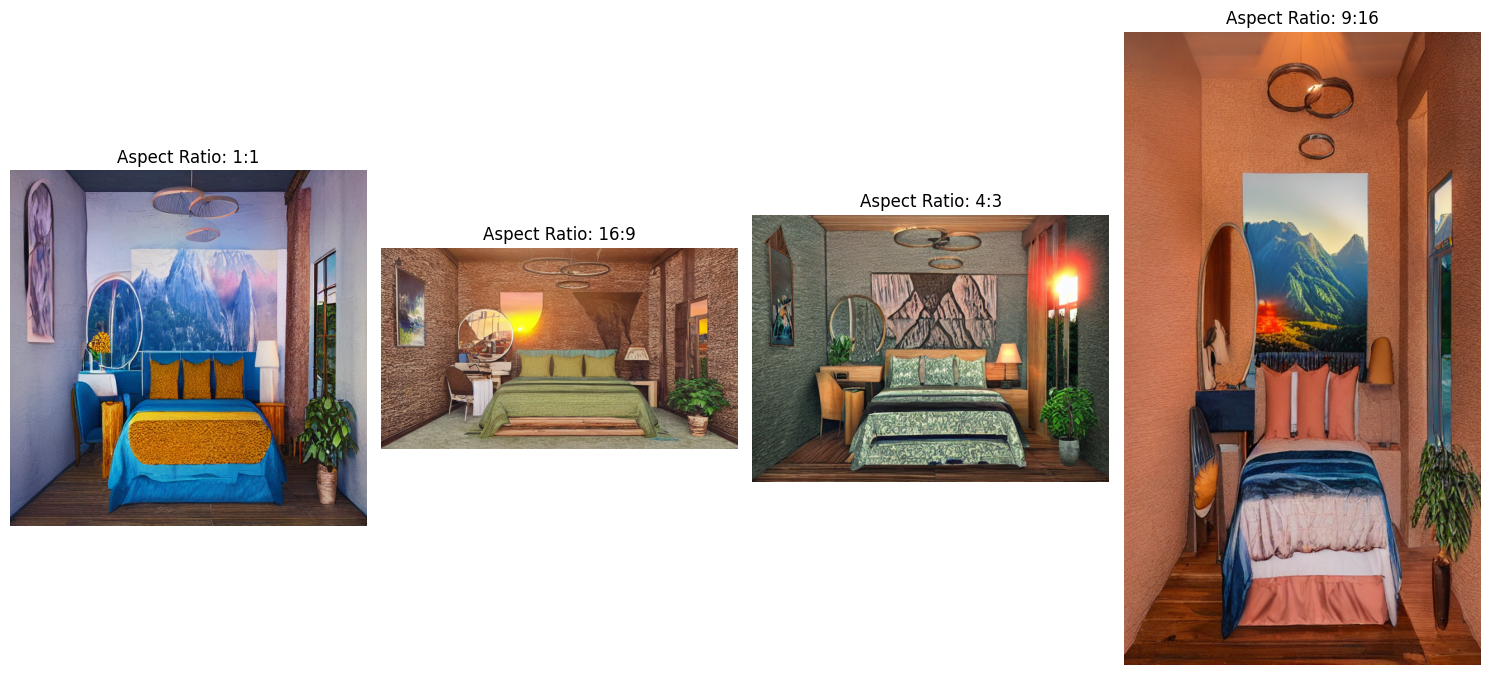

In [ ]:
import torch
import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import numpy as np

# loading the ControlNet model & Stable Diffusion pipeline
controlnet_depth_model = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float32
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet_depth_model,
    torch_dtype=torch.float32
)

# setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipe.to(device)

if torch.cuda.is_available():
    pipe.enable_xformers_memory_efficient_attention()

# loading the custom aspect ratio depth map
depth_map_path = "/content/Metadata/No Crop /2_nocrop.png"
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED) / 255.0

# enabling memory-efficient attention if GPU is available
if device == 'cuda':
    pipe.enable_xformers_memory_efficient_attention()

# loading the custom aspect ratio depth map
depth_map_path = "/content/Metadata/No Crop /2_nocrop.png"
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED) / 255.0

# defining the aspect ratios to test
aspect_ratios = {
    "1:1": (512, 512),
    "16:9": (768, 432),
    "4:3": (640, 480),
    "9:16": (432, 768)
}

# resizing & normalizing depth maps for each aspect ratio
generated_images = []
for ratio, (width, height) in aspect_ratios.items():
    # resizing depth map
    depth_map_resized = cv2.resize(depth_map, (width, height))
    if len(depth_map_resized.shape) == 2:
        depth_map_resized = np.stack([depth_map_resized] * 3, axis=-1)

    # converting depth map to torch tensor & adjusting shape
    depth_map_tensor = torch.tensor(depth_map_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # defining a sample prompt
    prompt = "A scenic landscape with mountains, rivers, and a vibrant sunset."

    # generating image using Stable Diffusion with ControlNet
    try :
      with torch.no_grad():
        generated_image = pipe(prompt, image=depth_map_tensor, num_inference_steps=30, width=width, height=height).images[0]
        generated_images.append((generated_image, ratio))
        generated_image.save(f'generated_image_{ratio}.png')
    except Exception as e:
      print(f"Error generating image for aspect ratio {ratio}: {e}")

# displaying all the generated images
import matplotlib.pyplot as plt

def plot_generated_images(generated_images):
    fig, axes = plt.subplots(1, len(generated_images), figsize=(15, 10))
    for (img, ratio), ax in zip(generated_images, axes):
        ax.imshow(img)
        ax.set_title(f"Aspect Ratio: {ratio}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_generated_images(generated_images)

**ANALYSIS OF THE GENERATION QUALITY AS PER THE ASPECT RATIO**

1. *1:1 Aspect Ratio [512 X 512 pixels]* -> It is the native resolution for Stable Diffusion models, thus generating the highest quality and clarity images.

2. *16:9 Aspect Ratio* -> Wider images tend to stretch or blur details from the sides since Stable
Diffusion model tries to force content in a non-native frame.

3. *4:3 Aspect Ratio* -> The distortions in 4:3 aspect ratio are relatively minimal because it is fairly close to model's native aspect ratio.

4. *9:16 Aspect Ratio* -> Tall Images (portrait mode) take a significant hit because Stable Diffusion model is not optimised for vertical content. Stretchy elements tend to occur more significantly.

**TASK 3 : What is the generation latency? Do you see some quick fixes to reduce it? Comment on how much latency you can reduce. What happens to the generation quality with reduced latency?**



Step 1 - What is Generation Latency? Measuring Generation Latency for the Stable Diffusion Model used above?

**Generation Latency** : Generation Latency is the time taken by a model to produce an output after recieving an input or prompt. For image-generating models like Stable Diffusion, it means the duration between when the model receives the prompt and when the final image is completed.

**Importance of Generation Latency** :
1. *User Experience* : Lower Generation Latency means faster responses, critical for real-time applications.
2. *Computational Efficiency* : Latency contributes to resource saving, thus the model can be scaled efficiently.
3. *Performance Metrics* : Latency is an important metric in determining how a model performs in production systems where throughput must be high.

**How to measure Generation Latency?** :
Developers often run the process of generation multiple times just to average the time taken by each generation. This may be done with benchmarking tools or by typical timing functions, like Python's time.time() or time.perf_counter().


In [ ]:
import time

latencies = []

for ratio, (width, height) in aspect_ratios.items():
    start_time = time.time()  # starting timer

    # performing image generation as in Task 2
    with torch.no_grad():
        generated_image = pipe(prompt, image=depth_map_tensor, num_inference_steps=30, width=width, height=height).images[0]

    latency = time.time() - start_time  # calculating latency
    latencies.append((ratio, latency))
    print(f"Generation Latency for {ratio}: {latency:.2f} seconds")

Step 2 - Quick fixes to reduce generation latency & their impact on the generation quality.

**Fix 1 : Reducing the Number of Inference Steps**

In [ ]:
generated_image = pipe(prompt, image=depth_map_tensor, num_inference_steps=20, width=width, height=height).images[0]
# here, the number of inference steps is reduced to 20, instead of 30.

**Explanation** : Since each step performs several model computations, reducing the number of inference steps result in large latency reductions.

**Typical Latency Reductions** : Latency can be reduced by nearly 20-30% with minimal impact on image quality.

**Quality Impact** : Fewer steps result in a significant reduction of many image details in the complex regions. However, a modest reduction usually has a minimal effect on quality.

**Fix 2 : Enabling Memory-Efficient Attention (Xformers)**

Enabling memory-efficient attention through pipe.enable_xformers_memory_efficient_attention() is already implemented to generate images in Task 1.

**Explanation** : Enabling memory-efficient attention speeds up the process and saves on GPU memory.

**Typical Latency Reductions** : Latency can be reduced by nearly 10-20% based on the GPU used.

**Quality Impact** : Quality of generated images do not usually suffer through this method of optimisation. However, this optimisation method might not work wiht all GPUs.




**Fix 3 : Reducing Image Resolution**

**Explanation** : Generating images at lower resolutions reduces the processing time.

**Typical Latency Reductions** : Latency can be reduced by nearly 25-50%.

**Quality Impact** : It significantly reduces details in the output image, so it is applied when losing some quality is tolerable.

**Fix 4 : Use Mixed Precision (FP16)**

**Explanation** : Since mixed proportion uses FP16, computation can be sped up and memory usage is also reduced.

**Typical Latency Reducitons** : Latency can be reduced by nearly 15-30% on supported hardware.

**Quality Impact** : Minimal Impact on quality of the generated image.